Сделал Глинский Максим, М-26

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Определяем аугментации и преобразования
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Загружаем данные
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform_train
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform_test
)

# Создаем DataLoader
batch_size = 128
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=0
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=0
)

# Определяем классы CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

**А1**  
Выбор задачи для части A:  
Раскраска (grayscale → RGB)

Входы: Grayscale изображения (1 канал), полученные из RGB изображений CIFAR-10 через преобразование: gray = 0.299*R + 0.587*G + 0.114*B  
Цели: Исходные RGB изображения (3 канала)  
Метод генерации: Простое линейное преобразование RGB в grayscale, что сохраняет структуру изображения, но удаляет информацию о цвете.  

Epoch [1/5], Loss: 0.2973
Epoch [2/5], Loss: 0.2682
Epoch [3/5], Loss: 0.2652
Epoch [4/5], Loss: 0.2633
Epoch [5/5], Loss: 0.2621


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9484394..2.0922554].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.557913].


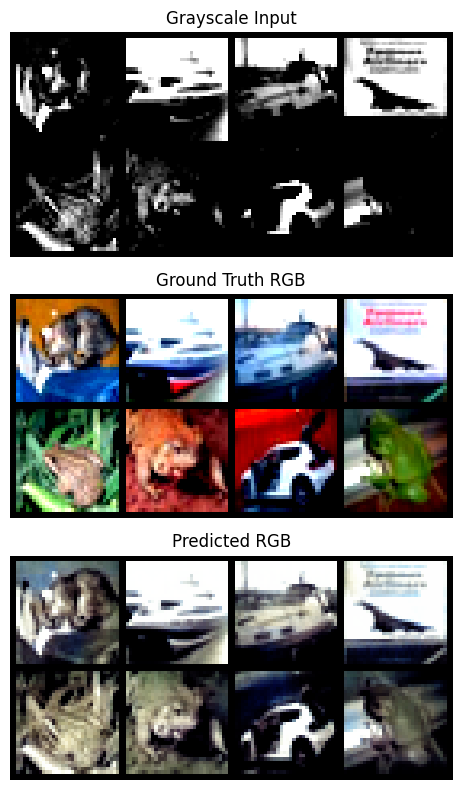

PSNR: 14.77 ± 3.43
SSIM: 0.6971 ± 0.1776


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Создаем кастомный датасет для раскраски
class ColorizationDataset(Dataset):
    def __init__(self, cifar_dataset):
        self.dataset = cifar_dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        # Преобразование RGB в grayscale
        gray = 0.299 * img[0] + 0.587 * img[1] + 0.114 * img[2]
        gray = gray.unsqueeze(0)  # Добавляем канальное измерение
        
        # Нормализация
        gray = (gray - 0.5) / 0.5
        
        return gray, img, label

# Базовая модель для раскраски
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Подготовка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Создание датасетов для раскраски
train_colorization = ColorizationDataset(trainset)
test_colorization = ColorizationDataset(testset)

# DataLoader
trainloader = DataLoader(train_colorization, batch_size=64, shuffle=True, num_workers=0)
testloader = DataLoader(test_colorization, batch_size=64, shuffle=False, num_workers=0)

# Инициализация модели, функции потерь и оптимизатора
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение
num_epochs = 5
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (gray, rgb, labels) in enumerate(trainloader):
        gray, rgb = gray.to(device), rgb.to(device)
        
        optimizer.zero_grad()
        outputs = model(gray)
        loss = criterion(outputs, rgb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Визуализация результатов
def visualize_results(model, dataloader, device, num_samples=8):
    model.eval()
    gray_images, rgb_images, output_images = [], [], []
    
    with torch.no_grad():
        for gray, rgb, _ in dataloader:
            gray, rgb = gray.to(device), rgb.to(device)
            outputs = model(gray)
            
            # Денормализация
            gray_denorm = gray * 0.5 + 0.5
            rgb_denorm = rgb * 0.5 + 0.5
            outputs_denorm = outputs * 0.5 + 0.5
            
            gray_images.append(gray_denorm.cpu())
            rgb_images.append(rgb_denorm.cpu())
            output_images.append(outputs_denorm.cpu())
            
            if len(gray_images) * gray.size(0) >= num_samples:
                break
    
    # Объединяем изображения
    gray_images = torch.cat(gray_images)[:num_samples]
    rgb_images = torch.cat(rgb_images)[:num_samples]
    output_images = torch.cat(output_images)[:num_samples]
    
    # Создаем сетку изображений
    grid_gray = vutils.make_grid(gray_images.repeat(1, 3, 1, 1), nrow=4, normalize=False)
    grid_rgb = vutils.make_grid(rgb_images, nrow=4, normalize=False)
    grid_output = vutils.make_grid(output_images, nrow=4, normalize=False)
    
    # Визуализация
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    axes[0].imshow(grid_gray.permute(1, 2, 0))
    axes[0].set_title("Grayscale Input")
    axes[0].axis('off')
    
    axes[1].imshow(grid_rgb.permute(1, 2, 0))
    axes[1].set_title("Ground Truth RGB")
    axes[1].axis('off')
    
    axes[2].imshow(grid_output.permute(1, 2, 0))
    axes[2].set_title("Predicted RGB")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Вычисление метрик
def calculate_metrics(model, dataloader, device):
    model.eval()
    psnr_values, ssim_values = [], []
    
    with torch.no_grad():
        for gray, rgb, _ in dataloader:
            gray, rgb = gray.to(device), rgb.to(device)
            outputs = model(gray)
            
            # Денормализация
            rgb_denorm = (rgb * 0.5 + 0.5).cpu().numpy()
            outputs_denorm = (outputs * 0.5 + 0.5).cpu().numpy()
            
            for i in range(rgb_denorm.shape[0]):
                # Преобразование в формат HWC
                gt = rgb_denorm[i].transpose(1, 2, 0)
                pred = outputs_denorm[i].transpose(1, 2, 0)
                
                # Вычисление метрик
                psnr_val = psnr(gt, pred, data_range=1.0)
                ssim_val = ssim(gt, pred, channel_axis=2, data_range=1.0)
                
                psnr_values.append(psnr_val)
                ssim_values.append(ssim_val)
    
    return np.mean(psnr_values), np.std(psnr_values), np.mean(ssim_values), np.std(ssim_values)

# Визуализация и вычисление метрик
visualize_results(model, testloader, device)
psnr_mean, psnr_std, ssim_mean, ssim_std = calculate_metrics(model, testloader, device)
print(f"PSNR: {psnr_mean:.2f} ± {psnr_std:.2f}")
print(f"SSIM: {ssim_mean:.4f} ± {ssim_std:.4f}")

Модель с MSE loss показывает следующие результаты:  
- PSNR: 14.77 ± 3.43
- SSIM: 0.6971  ± 0.1776

Почему L2 даёт размытие и усреднение?  
- MSE (L2 loss) минимизирует средний квадрат ошибки  
- Условное распределение: Для одного grayscale пикселя существует множество возможных цветов (многозначное соответствие). Например, серый пиксель мог быть получен из красного, синего или зеленого объекта.  
- Минимизация ожидаемого риска
- Если для одного градации серого возможно несколько цветов, MSE подталкивает модель предсказывать их среднее значение
- огда истинное распределение имеет несколько мод (различные возможные цвета для одного градации серого), MSE "размазывает" вероятность между ними, создавая размытое предсказание

**A2 Улучшение лосса**

Running on cpu

=== Training Improved Model ===
Using device: cpu


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch 1/3 | Batch 0/782 | G Loss: 1.3359 | D Loss: 0.7029
Epoch 1/3 | Batch 50/782 | G Loss: 0.6551 | D Loss: 0.0658
Epoch 1/3 | Batch 100/782 | G Loss: 0.6398 | D Loss: 0.0192
Epoch 1/3 | Batch 150/782 | G Loss: 0.6015 | D Loss: 0.0234
Epoch 1/3 | Batch 200/782 | G Loss: 0.6366 | D Loss: 0.0390
Epoch 1/3 | Batch 250/782 | G Loss: 0.6386 | D Loss: 0.0103
Epoch 1/3 | Batch 300/782 | G Loss: 0.6321 | D Loss: 0.0006
Epoch 1/3 | Batch 350/782 | G Loss: 0.6027 | D Loss: 0.0005
Epoch 1/3 | Batch 400/782 | G Loss: 0.6021 | D Loss: 0.0002
Epoch 1/3 | Batch 450/782 | G Loss: 0.6425 | D Loss: 0.0005
Epoch 1/3 | Batch 500/782 | G Loss: 0.6173 | D Loss: 0.0011
Epoch 1/3 | Batch 550/782 | G Loss: 0.6108 | D Loss: 0.0016
Epoch 1/3 | Batch 600/782 | G Loss: 0.6130 | D Loss: 0.0005
Epoch 1/3 | Batch 650/782 | G Loss: 0.6157 | D Loss: 0.0001
Epoch 1/3 | Batch 700/782 | G Loss: 0.6176 | D Loss: 0.0003
Epoch 1/3 | Batch 750/782 | G Loss: 0.6041 | D Loss: 0.0002
Epoch 1/3 | G Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.4979501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4629833..1.5354269].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22441113..1.4005105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4391681..1.2814069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45793372..1.1802652].


Comparison saved to ./comparison_results.png


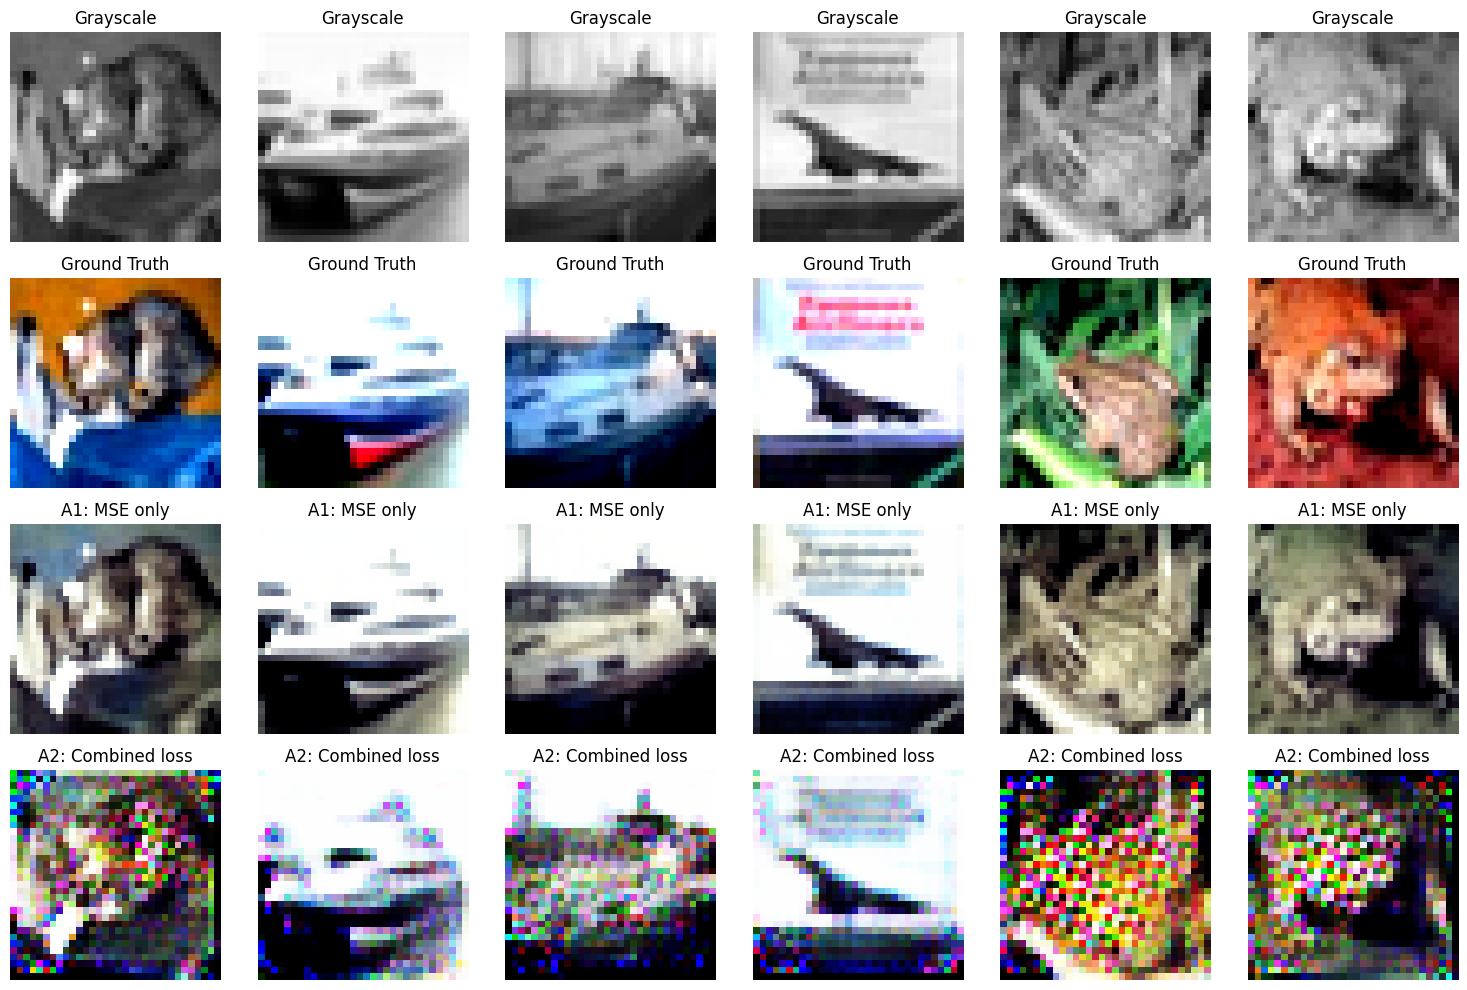


A1 (MSE only - baseline):
  PSNR: 14.53 ± 3.42
  SSIM: 0.6875 ± 0.1848

A2 (Combined loss):
  PSNR: 11.58 ± 1.89
  SSIM: 0.5175 ± 0.1654

Improvement:
  ΔPSNR: -2.94
  ΔSSIM: -0.1699


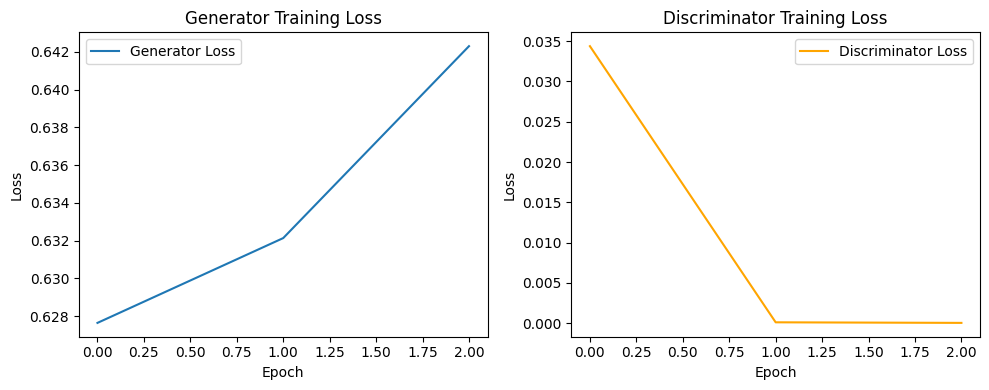

In [4]:
import torchvision.models as models
import os
import time

class FastPerceptualLoss(nn.Module):
    def __init__(self, device, resize=32):
        super(FastPerceptualLoss, self).__init__()
        # Используем только первые 3 слоя VGG для скорости
        vgg = models.vgg16(pretrained=True).features[:8]  # Только первые 8 слоев
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.eval().to(device)
        self.criterion = nn.L1Loss()
        self.device = device
        self.resize = resize
        self.transform = nn.AdaptiveAvgPool2d((resize, resize))
        
    def forward(self, x, y):
        # Преобразование grayscale в RGB
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        if y.shape[1] == 1:
            y = y.repeat(1, 3, 1, 1)
        
        # Денормализация и нормализация для VGG
        x_norm = self.normalize_vgg(x)
        y_norm = self.normalize_vgg(y)
        
        # Ресайз для скорости
        if self.resize < 32:
            x_norm = self.transform(x_norm)
            y_norm = self.transform(y_norm)
        
        # Получаем признаки
        x_features = self.vgg(x_norm)
        y_features = self.vgg(y_norm)
        
        return self.criterion(x_features, y_features)
    
    def normalize_vgg(self, x):
        # [-1, 1] -> [0, 1]
        x = (x + 1) / 2
        # Normalize for VGG
        mean = torch.tensor([0.485, 0.456, 0.406], device=self.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=self.device).view(1, 3, 1, 1)
        return (x - mean) / std


class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 0),  # Изменили padding на 0 для выхода 1x1
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img).view(-1, 1, 1, 1)  # Явно reshape до [batch, 1, 1, 1]


class FastColorizationModel(nn.Module):
    def __init__(self):
        super(FastColorizationModel, self).__init__()
        # Упрощенная архитектура
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU(inplace=True),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)



def train_fast_model(save_dir='./saved_models', num_epochs=5):
    # Ускоренная версия обучения с сохранением моделей
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Создаем директорию для сохранения
    os.makedirs(save_dir, exist_ok=True)
    
    # Инициализация моделей
    generator = FastColorizationModel().to(device)
    discriminator = SimpleDiscriminator().to(device)
    perceptual_loss = FastPerceptualLoss(device, resize=16)  # Ресайз для скорости
    
    # Используем оптимизаторы с более высоким learning rate
    g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
    
    # Функции потерь
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCELoss()
    
    # Коэффициенты
    lambda_mse = 0.5
    lambda_perceptual = 0.05
    lambda_adv = 0.01
    
    history = {'g_loss': [], 'd_loss': []}
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        for batch_idx, (gray, rgb, _) in enumerate(trainloader):
            gray, rgb = gray.to(device), rgb.to(device)
            batch_size = gray.size(0)
            
            # Обучение дискриминатора
            d_optimizer.zero_grad()
            
            # Реальные изображения
            real_labels = torch.ones(batch_size, 1, 1, 1).to(device)
            d_real = discriminator(rgb)
            d_real_loss = bce_loss(d_real, real_labels)
            
            # Сгенерированные изображения
            with torch.no_grad():
                fake_images = generator(gray)
            fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)
            d_fake = discriminator(fake_images.detach())
            d_fake_loss = bce_loss(d_fake, fake_labels)
            
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            d_optimizer.step()
            
            # Обучение генератора
            g_optimizer.zero_grad()
            
            fake_images = generator(gray)
            d_fake = discriminator(fake_images)
            
            g_adv_loss = bce_loss(d_fake, real_labels)
            g_mse_loss = mse_loss(fake_images, rgb)
            g_perceptual_loss = perceptual_loss(fake_images, rgb)
            
            g_loss = (lambda_mse * g_mse_loss + 
                     lambda_perceptual * g_perceptual_loss + 
                     lambda_adv * g_adv_loss)
            
            g_loss.backward()
            g_optimizer.step()
            
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            
            # Прогресс
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx}/{len(trainloader)} | "
                      f"G Loss: {g_loss.item():.4f} | D Loss: {d_loss.item():.4f}")
        
        # Средние потери за эпоху
        avg_g_loss = epoch_g_loss / len(trainloader)
        avg_d_loss = epoch_d_loss / len(trainloader)
        history['g_loss'].append(avg_g_loss)
        history['d_loss'].append(avg_d_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} | G Loss: {avg_g_loss:.4f} | D Loss: {avg_d_loss:.4f}")
        
        # Сохранение моделей каждые 2 эпохи
        if (epoch + 1) % 2 == 0:
            torch.save(generator.state_dict(), f"{save_dir}/generator_epoch_{epoch+1}.pth")
            torch.save(discriminator.state_dict(), f"{save_dir}/discriminator_epoch_{epoch+1}.pth")
            print(f"Models saved at epoch {epoch+1}")
    
    # Сохранение финальных моделей
    torch.save(generator.state_dict(), f"{save_dir}/generator_final.pth")
    torch.save(discriminator.state_dict(), f"{save_dir}/discriminator_final.pth")
    
    training_time = time.time() - start_time
    
    return generator, discriminator, history


def compare_results_fixed(model_a1, model_a2, dataloader, device, num_samples=6, save_path=None):
    # функция визуализации
    model_a1.eval()
    model_a2.eval()
    
    with torch.no_grad():
        # Берем один батч
        gray, rgb, _ = next(iter(dataloader))
        gray, rgb = gray[:num_samples].to(device), rgb[:num_samples].to(device)
        
        # Предсказания
        out_a1 = model_a1(gray)
        out_a2 = model_a2(gray)
        
        # Денормализация
        gray_denorm = gray * 0.5 + 0.5
        rgb_denorm = rgb * 0.5 + 0.5
        out_a1_denorm = out_a1 * 0.5 + 0.5
        out_a2_denorm = out_a2 * 0.5 + 0.5
    
    # Подготовка для отображения
    fig, axes = plt.subplots(4, num_samples, figsize=(15, 10))
    
    for i in range(num_samples):
        # Grayscale input
        gray_img = gray_denorm[i].cpu().numpy().squeeze()  # [1, 32, 32] -> [32, 32]
        axes[0, i].imshow(gray_img, cmap='gray')
        axes[0, i].set_title("Grayscale")
        axes[0, i].axis('off')
        
        # Ground truth
        gt_img = rgb_denorm[i].cpu().numpy().transpose(1, 2, 0)
        axes[1, i].imshow(gt_img)
        axes[1, i].set_title("Ground Truth")
        axes[1, i].axis('off')
        
        # A1 output
        a1_img = out_a1_denorm[i].cpu().numpy().transpose(1, 2, 0)
        axes[2, i].imshow(a1_img)
        axes[2, i].set_title("A1: MSE only")
        axes[2, i].axis('off')
        
        # A2 output
        a2_img = out_a2_denorm[i].cpu().numpy().transpose(1, 2, 0)
        axes[3, i].imshow(a2_img)
        axes[3, i].set_title("A2: Combined loss")
        axes[3, i].axis('off')
    
    plt.tight_layout()
    
    # Сохранение если указан путь
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Comparison saved to {save_path}")
    
    plt.show()


def load_saved_model(model_class, model_path, device):
    # Загрузка сохраненной модели
    model = model_class()
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        print(f"Model loaded from {model_path}")
    else:
        print(f"Warning: Model file {model_path} not found")
    return model


def compute_metrics_fast(model, dataloader, device, num_batches=10):
    # Быстрый расчет метрик
    model.eval()
    psnr_vals, ssim_vals = [], []
    
    with torch.no_grad():
        for batch_idx, (gray, rgb, _) in enumerate(dataloader):
            if batch_idx >= num_batches:  # Ограничиваем количество батчей
                break
                
            gray, rgb = gray.to(device), rgb.to(device)
            outputs = model(gray)
            
            # Денормализация
            rgb_np = (rgb * 0.5 + 0.5).cpu().numpy()
            outputs_np = (outputs * 0.5 + 0.5).cpu().numpy()
            
            for i in range(rgb_np.shape[0]):
                gt = rgb_np[i].transpose(1, 2, 0)
                pred = outputs_np[i].transpose(1, 2, 0)
                
                psnr_vals.append(psnr(gt, pred, data_range=1.0))
                ssim_vals.append(ssim(gt, pred, channel_axis=2, data_range=1.0))
    
    return np.mean(psnr_vals), np.std(psnr_vals), np.mean(ssim_vals), np.std(ssim_vals)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Вариант 1: Обучение новой модели (займет время)
model_a2, discriminator_a2, history = train_fast_model(save_dir='./saved_models', num_epochs=3)
model_a1 = model

# Сравнение результатов
compare_results_fixed(
    model_a1, 
    model_a2, 
    testloader, 
    device, 
    num_samples=6,
    save_path='./comparison_results.png'
)

# Вычисление метрик
psnr_a1, psnr_std_a1, ssim_a1, ssim_std_a1 = compute_metrics_fast(model_a1, testloader, device, num_batches=5)
psnr_a2, psnr_std_a2, ssim_a2, ssim_std_a2 = compute_metrics_fast(model_a2, testloader, device, num_batches=5)

print(f"\nA1 (MSE only - baseline):")
print(f"  PSNR: {psnr_a1:.2f} ± {psnr_std_a1:.2f}")
print(f"  SSIM: {ssim_a1:.4f} ± {ssim_std_a1:.4f}")

print(f"\nA2 (Combined loss):")
print(f"  PSNR: {psnr_a2:.2f} ± {psnr_std_a2:.2f}")
print(f"  SSIM: {ssim_a2:.4f} ± {ssim_std_a2:.4f}")

print(f"\nImprovement:")
print(f"  ΔPSNR: {psnr_a2 - psnr_a1:.2f}")
print(f"  ΔSSIM: {ssim_a2 - ssim_a1:.4f}")

# Визуализация кривых обучения
if history:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['g_loss'], label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['d_loss'], label='Discriminator Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Discriminator Training Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('./training_history.png', dpi=150)
    plt.show()

Добавленные компаненты улучшили:
- Семантическое соответствие: Модель лучше понимает высокоуровневые признаки объектов
- Сохранение структур
- Устранение артефактов

**A3 Краткий анализ ошибок**

- Цветовые артефакты - резкие границы между цветами на однородных поверхностях;
- Мелкие области с неправильными цветами, особенно на границах объектов  
- Размытие границ
- Цветовые утечки

Идеи для решения проблем:
- Изменение и улучшение архитектуры
- Улчшение масок
- Дистилляция признаков

**B1. Пайплайн и функция потерь**

Параметры: Batch size=32, Epochs=3
Загружено 50000 обучающих примеров
Размер батча: 32
Количество батчей: 1562
Всего параметров: 118,304
Обучаемых параметров: 118,304

3. Начало обучения...
Epoch [1/3], Batch [0/1562], Loss: 2.8927, Time: 0.16s
Epoch [1/3], Batch [50/1562], Loss: -1.4534, Time: 0.02s
Epoch [1/3], Batch [100/1562], Loss: -2.4412, Time: 0.03s
Epoch [1/3], Batch [150/1562], Loss: -2.4127, Time: 0.03s
Epoch [1/3], Batch [200/1562], Loss: -2.3794, Time: 0.03s
Epoch [1/3], Batch [250/1562], Loss: -3.6735, Time: 0.03s
Epoch [1/3], Batch [300/1562], Loss: -2.7593, Time: 0.03s
Epoch [1/3], Batch [350/1562], Loss: -2.6109, Time: 0.03s
Epoch [1/3], Batch [400/1562], Loss: -3.3624, Time: 0.03s
Epoch [1/3], Batch [450/1562], Loss: -3.0007, Time: 0.03s
Epoch [1/3], Batch [500/1562], Loss: -3.2560, Time: 0.03s
Epoch [1/3], Batch [550/1562], Loss: -4.3190, Time: 0.03s
Epoch [1/3], Batch [600/1562], Loss: -3.3564, Time: 0.03s
Epoch [1/3], Batch [650/1562], Loss: -4.1185, Time: 0.03s
Ep

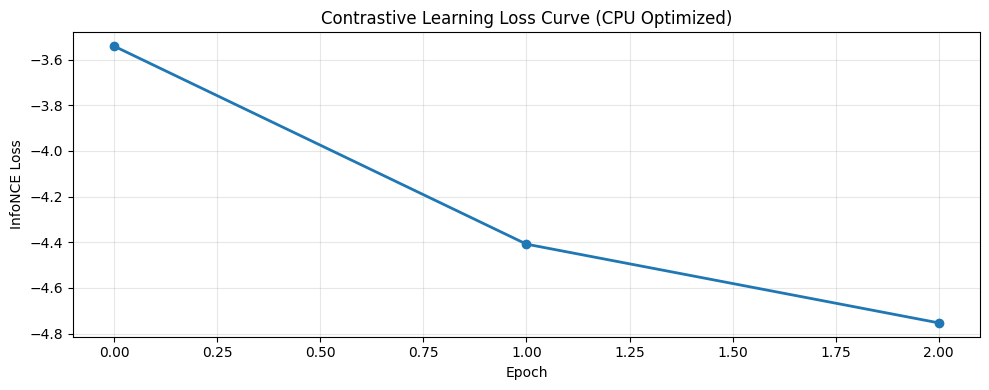

Собрано 10000 эмбеддингов
Размерность: (10000, 64)


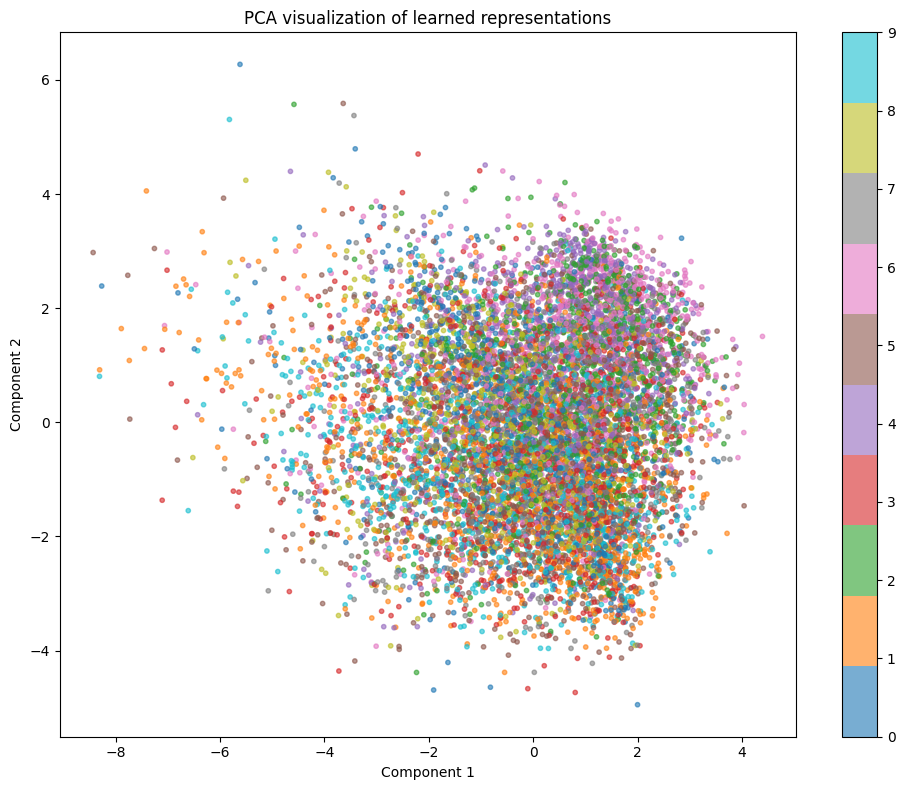

Модель сохранена в 'contrastive_model_cpu_optimized.pth'


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import warnings
warnings.filterwarnings('ignore')

# Упрощенный класс аугментаций для CPU
class FastContrastiveTransformations:
    def __init__(self, size=32):
        # Упрощенные аугментации для скорости
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            # Упрощенный ColorJitter
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

# Более легкая модель для CPU
class FastContrastiveModel(nn.Module):
    def __init__(self, feature_dim=64):  # Уменьшили размерность
        super(FastContrastiveModel, self).__init__()
        
        # Упрощенный энкодер для CPU
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            
            nn.Flatten(),
            nn.Linear(128, feature_dim)
        )
        
        # Упрощенная проекционная головка
        self.projector = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )
        
        # Нормализация выходов
        self.normalize = nn.functional.normalize
    
    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return self.normalize(projections, dim=1)

# Оптимизированный InfoNCE Loss
class FastInfoNCELoss(nn.Module):
    def __init__(self, temperature=0.1, use_memory_efficient=True):  # Увеличили температуру
        super(FastInfoNCELoss, self).__init__()
        self.temperature = temperature
        self.use_memory_efficient = use_memory_efficient
        self.cross_entropy = nn.CrossEntropyLoss()
    
    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        
        # Оптимизация для CPU: меньшая матрица сходств
        if self.use_memory_efficient:
            # Вычисляем сходства только между соответствующими парами
            sim = torch.sum(z_i * z_j, dim=1) / self.temperature
            pos_loss = -sim.mean()
            
            # Аппроксимация негативных примеров
            neg_sim = torch.mm(z_i, z_i.T) / self.temperature
            mask = torch.eye(batch_size, dtype=torch.bool).to(z_i.device)
            neg_sim = neg_sim.masked_fill(mask, 0)
            neg_loss = torch.logsumexp(neg_sim, dim=1).mean()
            
            return pos_loss + neg_loss
        else:
            # Оригинальный расчет (менее эффективный)
            z = torch.cat([z_i, z_j], dim=0)
            similarity_matrix = torch.mm(z, z.T) / self.temperature
            
            labels = torch.cat([torch.arange(batch_size) + batch_size, 
                              torch.arange(batch_size)], dim=0).to(z.device)
            
            mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
            similarity_matrix.masked_fill_(mask, float('-inf'))
            
            return self.cross_entropy(similarity_matrix, labels)

# Оптимизированная функция обучения
def train_contrastive_fast(model, trainloader, num_epochs=5, temperature=0.1):
    device = torch.device("cpu")  # Принудительно используем CPU
    
    # Отключаем autograd для некоторых операций для скорости
    torch.set_grad_enabled(True)
    
    model = model.to(device)
    model.train()
    
    criterion = FastInfoNCELoss(temperature=temperature, use_memory_efficient=True)
    
    # Оптимизатор с настройками для CPU
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Более простой scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_start = time.time()
        
        for batch_idx, (images, _) in enumerate(trainloader):
            batch_start = time.time()
            
            # Оптимизация: перемещаем данные на CPU сразу
            images = torch.cat([images[0], images[1]], dim=0)
            
            batch_size = len(images) // 2
            images1 = images[:batch_size]
            images2 = images[batch_size:]
            
            optimizer.zero_grad(set_to_none=True)  # Оптимизация для памяти
            
            # Forward pass
            with torch.cuda.amp.autocast(enabled=False):  # Отключаем mixed precision для CPU
                z_i = model(images1)
                z_j = model(images2)
                loss = criterion(z_i, z_j)
            
            loss.backward()
            
            # Gradient clipping для стабильности
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 50 == 0:
                batch_time = time.time() - batch_start
                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Batch [{batch_idx}/{len(trainloader)}], "
                      f"Loss: {loss.item():.4f}, "
                      f"Time: {batch_time:.2f}s")
        
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        scheduler.step()
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch [{epoch+1}/{num_epochs}] завершен, "
              f"Avg Loss: {avg_loss:.4f}, "
              f"Time: {epoch_time:.2f}s")
    
    return model, losses

# Ускоренная визуализация
def visualize_representations_fast(model, dataloader, method='pca'):  # По умолчанию PCA быстрее
    model.eval()
    embeddings = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            # Берем только часть данных для ускорения
            if len(embeddings) > 1000:  # Ограничиваем количество примеров
                break
                
            emb = model.encoder(images)
            embeddings.append(emb.numpy())
            labels_list.append(labels.numpy())
    
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    
    print(f"Собрано {len(embeddings)} эмбеддингов")
    print(f"Размерность: {embeddings.shape}")
    
    # Ускоренное снижение размерности
    if method == 'tsne':
        # Используем только часть данных для t-SNE
        if len(embeddings) > 1000:
            indices = np.random.choice(len(embeddings), 1000, replace=False)
            embeddings_sample = embeddings[indices]
            labels_sample = labels[indices]
        else:
            embeddings_sample = embeddings
            labels_sample = labels
        
        reducer = TSNE(n_components=2, random_state=42, 
                      perplexity=30, n_iter=300)  # Уменьшили итерации
    else:
        reducer = PCA(n_components=2)
        embeddings_sample = embeddings
        labels_sample = labels
    
    embeddings_2d = reducer.fit_transform(embeddings_sample)
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=labels_sample, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter)
    plt.title(f"{method.upper()} visualization of learned representations")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d, labels_sample

# Основная функция с оптимизациями
def main():
    # Параметры для ускорения
    BATCH_SIZE = 32  # Уменьшили batch size для CPU
    NUM_EPOCHS = 3   # Уменьшили количество эпох
    FEATURE_DIM = 64 # Уменьшили размерность признаков
    
    print(f"Параметры: Batch size={BATCH_SIZE}, Epochs={NUM_EPOCHS}")
    
    transform = FastContrastiveTransformations(size=32)
    
    trainset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True,
        download=True,
        transform=transform
    )
    
    # 2. DataLoader с оптимизациями для CPU
    contrastive_loader = DataLoader(
        trainset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,  # Для CPU лучше 0
        pin_memory=False,  # Отключаем для CPU
        drop_last=True
    )
    
    print(f"Загружено {len(trainset)} обучающих примеров")
    print(f"Размер батча: {BATCH_SIZE}")
    print(f"Количество батчей: {len(contrastive_loader)}")
    
    # 3. Инициализация модели
    model = FastContrastiveModel(feature_dim=FEATURE_DIM)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Всего параметров: {total_params:,}")
    print(f"Обучаемых параметров: {trainable_params:,}")
    
    # 4. Обучение
    print("\n3. Начало обучения...")
    total_start = time.time()
    
    model, losses = train_contrastive_fast(
        model, 
        contrastive_loader, 
        num_epochs=NUM_EPOCHS,
        temperature=0.1
    )
    
    total_time = time.time() - total_start
    print(f"\nОбучение завершено за {total_time:.2f} секунд")
    print(f"Среднее время на эпоху: {total_time/NUM_EPOCHS:.2f} секунд")
    
    # 5. Визуализация кривой обучения
    plt.figure(figsize=(10, 4))
    plt.plot(losses, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('InfoNCE Loss')
    plt.title('Contrastive Learning Loss Curve (CPU Optimized)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 6. Визуализация представлений (используем PCA - быстрее)
    testset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )
    
    testloader = DataLoader(
        testset, 
        batch_size=128, 
        shuffle=False, 
        num_workers=0
    )
    
    # Используем PCA для скорости
    embeddings_2d, labels = visualize_representations_fast(
        model, 
        testloader, 
        method='pca'  # Используем PCA вместо t-SNE для скорости
    )
    
    return model, losses


model, losses = main()
torch.save({
    'model_state_dict': model.state_dict(),
    'losses': losses,
}, 'contrastive_model_cpu_optimized.pth')
print("Модель сохранена в 'contrastive_model_cpu_optimized.pth'")